# To-Dos
- [ ] Redo with full gemeente datasets
- [ ] Figure out how to create rows for totals by crime category
- [ ] Look up how to use transform vs. agg
- [ ] Keep overall crime per gemeente in final dataset; can then check violent crime as a percent of total crime in each gemeente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# Data prep

## Import crime data

In [2]:
## Data extracted from: https://data.politie.nl/portal.html?_la=nl&_catalog=Politie&tableId=47013NED&_theme=114
## On: 12-07-2025

crime_data = 'RegisteredCrimes_AllCrimes_Gemeenten_2024.csv'
metadata = 'AlleMisdrijven_Metadata.csv'

meta_df = pd.read_csv(metadata, sep=';', index_col=1, header=1)
meta_df

,ID,ShortTitle,Identifier,Summary,Modified,ReasonDelivery,ExplanatoryText,Language,Catalog,Frequency,Period,ShortDescription,Description,DefaultPresentation,DefaultSelection,GraphTypes,OutputStatus,Source,MetaDataModified,SearchPriority
Title,,,,,,,,,,,,,,,,,,,,
"Geregistreerde misdrijven en aangiften; soort misdrijf, gemeente 2025",0,Misdrijven en aangiften per gemeente,47013NED,"Geregistreerde misdrijven, aangiften en intern...",2025-06-16T02:00:00,ActualiseringBijzonder,NaN,nl,Politie,Permaand,2012-2025,\nDeze tabel bevat cijfers over het aantal ger...,INHOUDSOPGAVE\n\n1. Toelichting\n2. Definities...,ts=1749630168797&graphtype=Table&r=RegioS&k=To...,$filter=((SoortMisdrijf eq '0.0.0 ')) and ((Pe...,"Table,Bar,Map",Regulier,&copy; Politie,2025-06-16T02:00:00,2.0
NaN,DataProperties,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,ID,ParentID,Type,Key,Title,Description,ReleasePolicy,Datatype,Unit,Decimals,Default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,NaN,Dimension,SoortMisdrijf,Soort misdrijf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,GeoDimension,RegioS,Regio's,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025 januari,2025MM01,NaN,Definitief,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025 februari,2025MM02,NaN,Definitief,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025 maart,2025MM03,NaN,Definitief,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
crime_df = pd.read_csv(crime_data, sep=';')
crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1
0,3492,0.0.0,GM1680,2012JJ00,925.0
1,3505,0.0.0,GM1680,2013JJ00,755.0
2,3518,0.0.0,GM1680,2014JJ00,664.0
3,3531,0.0.0,GM1680,2015JJ00,634.0
4,3544,0.0.0,GM1680,2016JJ00,616.0
...,...,...,...,...,...
263843,3847778,3.9.3,GM0999,2020JJ00,NaN
263844,3847791,3.9.3,GM0999,2021JJ00,NaN
263845,3847804,3.9.3,GM0999,2022JJ00,NaN
263846,3847817,3.9.3,GM0999,2023JJ00,NaN


## Extract crime metadata

In [4]:
print('Unique crime codes:')
print(crime_df['SoortMisdrijf'].unique())
print('Unqiue gemeente codes:')
print(crime_df['RegioS'].unique())
print('Unique year codes:')
print(crime_df['Perioden'].unique())

Unique crime codes:
['0.0.0 ' '1.1.1 ' '1.1.2 ' '1.2.1 ' '1.2.2 ' '1.2.3 ' '1.2.4 ' '1.2.5 '
 '1.3.1 ' '1.4.1 ' '1.4.2 ' '1.4.3 ' '1.4.4 ' '1.4.5 ' '1.4.6 ' '1.4.7 '
 '1.5.2 ' '1.6.1 ' '1.6.2 ' '1.6.3 ' '2.1.1 ' '2.2.1 ' '2.4.1 ' '2.4.2 '
 '2.5.1 ' '2.5.2 ' '2.6.1 ' '2.6.2 ' '2.6.3 ' '2.6.4 ' '2.6.5 ' '2.6.7 '
 '2.6.8 ' '2.6.9 ' '2.6.10' '2.6.11' '2.6.12' '2.6.13' '2.6.14' '2.7.2 '
 '2.7.3 ' '3.1.1 ' '3.1.2 ' '3.1.3 ' '3.2.1 ' '3.2.2 ' '3.3.2 ' '3.3.5 '
 '3.4.2 ' '3.5.2 ' '3.5.5 ' '3.6.4 ' '3.7.1 ' '3.7.2 ' '3.7.3 ' '3.7.4 '
 '3.9.1 ' '3.9.2 ' '3.9.3 ']
Unqiue gemeente codes:
['GM1680' 'GM0358' 'GM0197' 'GM0059' 'GM0482' 'GM0613' 'GM0361' 'GM0141'
 'GM0034' 'GM0484' 'GM1723' 'GM1959' 'GM0060' 'GM0307' 'GM0362' 'GM0363'
 'GM0200' 'GM0202' 'GM0106' 'GM0743' 'GM0744' 'GM0308' 'GM0489' 'GM0203'
 'GM0888' 'GM1954' 'GM0889' 'GM1945' 'GM1724' 'GM0893' 'GM0373' 'GM0748'
 'GM1859' 'GM1721' 'GM0753' 'GM0209' 'GM0375' 'GM0310' 'GM1728' 'GM0376'
 'GM0377' 'GM1901' 'GM0755' 'GM1681' 'GM0147' 'GM065

In [5]:
crime_codes = list(crime_df['SoortMisdrijf'].unique())
gemeente_codes = list(crime_df['RegioS'].unique())
year_codes = list(crime_df['Perioden'].unique())

In [6]:
crime_tuples = tuple(crime_codes)

crime_indices = []

for i in list(meta_df.index):
    if type(i) == float:
        continue
    elif i.startswith(crime_tuples):
        crime_indices.append(i)

crime_keys = []

for i in crime_indices:
    code_split = i.split(' ', maxsplit=1)
    crime_keys.append(code_split)


In [7]:
violent_crime = ['Zedendelicten','Moord, doodslag', 'Openlijk geweld (persoon)',
 'Bedreiging',
 'Mishandeling',
 'Straatroof',
 'Overval','Mensenhandel','Mensensmokkel', 'Kinderporno',
 'Kinderprostitutie']

In [8]:
crimekeys_df = pd.DataFrame(crime_keys,columns=['code','crime_name'])

violentcrime_df = crimekeys_df[crimekeys_df['crime_name'].isin(violent_crime)]

violentcrime_df.set_index(keys='code', inplace=True)

violentcrime_series = violentcrime_df['crime_name']

In [9]:
gmcodes_series = meta_df[meta_df['ID'].isin(gemeente_codes)]['ID']
yearcodes_series = meta_df[meta_df['ID'].isin(year_codes)]['ID']
gmcodes_series

Title
Aa en Hunze                    GM1680
Aalsmeer                       GM0358
Aalten                         GM0197
Achtkarspelen                  GM0059
Alblasserdam                   GM0482
                                ...  
Zwartewaterland                GM1896
Zwijndrecht                    GM0642
Zwolle                         GM0193
Buitenland                     GM0998
Gemeenten; niet in te delen    GM0999
Name: ID, Length: 344, dtype: object

In [10]:
violentcrime_dict = dict(violentcrime_series)
gm_dict = {}
for i, v in zip(gmcodes_series.index, gmcodes_series.values):
   gm_dict[v] = i

years_dict = {}
for i, v in zip(yearcodes_series.index, yearcodes_series.values):
    years_dict[v] = i


In [11]:
violentcrime_dict

{'1.4.1': 'Zedendelicten',
 '1.4.2': 'Moord, doodslag',
 '1.4.3': 'Openlijk geweld (persoon)',
 '1.4.4': 'Bedreiging',
 '1.4.5': 'Mishandeling',
 '1.4.6': 'Straatroof',
 '1.4.7': 'Overval',
 '1.6.3': 'Mensenhandel',
 '3.1.2': 'Mensensmokkel',
 '3.2.1': 'Kinderporno',
 '3.2.2': 'Kinderprostitutie'}

## Map crime, gemeente and year by codes to crime data

In [12]:
violentcrime_dict

{'1.4.1': 'Zedendelicten',
 '1.4.2': 'Moord, doodslag',
 '1.4.3': 'Openlijk geweld (persoon)',
 '1.4.4': 'Bedreiging',
 '1.4.5': 'Mishandeling',
 '1.4.6': 'Straatroof',
 '1.4.7': 'Overval',
 '1.6.3': 'Mensenhandel',
 '3.1.2': 'Mensensmokkel',
 '3.2.1': 'Kinderporno',
 '3.2.2': 'Kinderprostitutie'}

In [13]:
crime_df['SoortMisdrijf'] = crime_df['SoortMisdrijf'].apply(lambda x: x.strip())

In [14]:
crime_df['SoortMisdrijf'].unique()

array(['0.0.0', '1.1.1', '1.1.2', '1.2.1', '1.2.2', '1.2.3', '1.2.4',
       '1.2.5', '1.3.1', '1.4.1', '1.4.2', '1.4.3', '1.4.4', '1.4.5',
       '1.4.6', '1.4.7', '1.5.2', '1.6.1', '1.6.2', '1.6.3', '2.1.1',
       '2.2.1', '2.4.1', '2.4.2', '2.5.1', '2.5.2', '2.6.1', '2.6.2',
       '2.6.3', '2.6.4', '2.6.5', '2.6.7', '2.6.8', '2.6.9', '2.6.10',
       '2.6.11', '2.6.12', '2.6.13', '2.6.14', '2.7.2', '2.7.3', '3.1.1',
       '3.1.2', '3.1.3', '3.2.1', '3.2.2', '3.3.2', '3.3.5', '3.4.2',
       '3.5.2', '3.5.5', '3.6.4', '3.7.1', '3.7.2', '3.7.3', '3.7.4',
       '3.9.1', '3.9.2', '3.9.3'], dtype=object)

In [15]:
crime_df['crime_cat'] = crime_df['SoortMisdrijf'].map(violentcrime_dict)
crime_df['gemeente'] = crime_df['RegioS'].map(gm_dict)
crime_df['year'] = crime_df['Perioden'].map(years_dict)

In [16]:
crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1,crime_cat,gemeente,year
0,3492,0.0.0,GM1680,2012JJ00,925.0,NaN,Aa en Hunze,2012
1,3505,0.0.0,GM1680,2013JJ00,755.0,NaN,Aa en Hunze,2013
2,3518,0.0.0,GM1680,2014JJ00,664.0,NaN,Aa en Hunze,2014
3,3531,0.0.0,GM1680,2015JJ00,634.0,NaN,Aa en Hunze,2015
4,3544,0.0.0,GM1680,2016JJ00,616.0,NaN,Aa en Hunze,2016
...,...,...,...,...,...,...,...,...
263843,3847778,3.9.3,GM0999,2020JJ00,NaN,NaN,Gemeenten; niet in te delen,2020
263844,3847791,3.9.3,GM0999,2021JJ00,NaN,NaN,Gemeenten; niet in te delen,2021
263845,3847804,3.9.3,GM0999,2022JJ00,NaN,NaN,Gemeenten; niet in te delen,2022
263846,3847817,3.9.3,GM0999,2023JJ00,NaN,NaN,Gemeenten; niet in te delen,2023


In [17]:
crime_df['crime_cat'].unique()

array([nan, 'Zedendelicten', 'Moord, doodslag',
       'Openlijk geweld (persoon)', 'Bedreiging', 'Mishandeling',
       'Straatroof', 'Overval', 'Mensenhandel', 'Mensensmokkel',
       'Kinderporno', 'Kinderprostitutie'], dtype=object)

In [18]:
crime_df['gemeente'].nunique()

344

In [56]:
crime_df['gemeente'].unique()

array(['Aa en Hunze', 'Aalsmeer', 'Aalten', 'Achtkarspelen',
       'Alblasserdam', 'Albrandswaard', 'Alkmaar', 'Almelo', 'Almere',
       'Alphen aan den Rijn', 'Alphen-Chaam', 'Altena', 'Ameland',
       'Amersfoort', 'Amstelveen', 'Amsterdam', 'Apeldoorn', 'Arnhem',
       'Assen', 'Asten', 'Baarle-Nassau', 'Baarn', 'Barendrecht',
       'Barneveld', 'Beek (L.)', 'Beekdaelen', 'Beesel', 'Berg en Dal',
       'Bergeijk', 'Bergen (L.)', 'Bergen (NH.)', 'Bergen op Zoom',
       'Berkelland', 'Bernheze', 'Best', 'Beuningen', 'Beverwijk',
       'De Bilt', 'Bladel', 'Blaricum', 'Bloemendaal',
       'Bodegraven-Reeuwijk', 'Boekel', 'Borger-Odoorn', 'Borne',
       'Borsele', 'Boxtel', 'Breda', 'Bronckhorst', 'Brummen', 'Brunssum',
       'Bunnik', 'Bunschoten', 'Buren', 'Capelle aan den IJssel',
       'Castricum', 'Coevorden', 'Cranendonck', 'Culemborg', 'Dalfsen',
       'Dantumadiel', 'Delft', 'Deurne', 'Deventer', 'Diemen',
       'Dijk en Waard', 'Dinkelland', 'Doesburg', 'Doetinche

In [19]:
## Drop all rows were crime_cat is NaN after mapping
crime_df.dropna(subset=['crime_cat'], inplace=True)

In [20]:
crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1,crime_cat,gemeente,year
40248,590742,1.4.1,GM1680,2012JJ00,13.0,Zedendelicten,Aa en Hunze,2012
40249,590755,1.4.1,GM1680,2013JJ00,9.0,Zedendelicten,Aa en Hunze,2013
40250,590768,1.4.1,GM1680,2014JJ00,10.0,Zedendelicten,Aa en Hunze,2014
40251,590781,1.4.1,GM1680,2015JJ00,13.0,Zedendelicten,Aa en Hunze,2015
40252,590794,1.4.1,GM1680,2016JJ00,16.0,Zedendelicten,Aa en Hunze,2016
...,...,...,...,...,...,...,...,...
205707,2999528,3.2.2,GM0999,2020JJ00,NaN,Kinderprostitutie,Gemeenten; niet in te delen,2020
205708,2999541,3.2.2,GM0999,2021JJ00,NaN,Kinderprostitutie,Gemeenten; niet in te delen,2021
205709,2999554,3.2.2,GM0999,2022JJ00,NaN,Kinderprostitutie,Gemeenten; niet in te delen,2022
205710,2999567,3.2.2,GM0999,2023JJ00,NaN,Kinderprostitutie,Gemeenten; niet in te delen,2023


In [21]:
## Fill remaining NaN values in GeregistreerdeMisdrijven with 0
crime_df['GeregistreerdeMisdrijven_1'].fillna(value=0, inplace=True)

crime_df.rename(mapper={'RegioS':'Regions', 'Perioden':'Periods'}, axis=1, inplace=True)

C:\Users\chels\AppData\Local\Temp\ipykernel_24208\3992183514.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_df['GeregistreerdeMisdrijven_1'].fillna(value=0, inplace=True)


In [22]:
crime_df.isna().sum()

ID                            0
SoortMisdrijf                 0
Regions                       0
Periods                       0
GeregistreerdeMisdrijven_1    0
crime_cat                     0
gemeente                      0
year                          0
dtype: int64

## Import & extract population data

In [23]:
## Extracted from: https://opendata.cbs.nl/statline/#/CBS/en/dataset/37259eng/table?ts=1752340527100
## https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=37259eng&_theme=1178
## On: 12-07-2025
popdata = 'Bevolking_Gemeenten.csv'

# https://opendata.cbs.nl/statline/#/CBS/nl/dataset/37230ned/table?ts=1752318493150
# popdata = 'Pop_NL_MajorCities.csv'


popdata_df = pd.read_csv(popdata, sep=';')

popdata_df.head()

,ID,RegioS,Perioden,BevolkingAanHetBeginVanDePeriode_1,BevolkingAanHetEindeVanDePeriode_15
0,17340,GM1680,2002JJ00,25552.0,25305.0
1,17353,GM1680,2003JJ00,25305.0,25218.0
2,17366,GM1680,2004JJ00,25218.0,25329.0
3,17379,GM1680,2005JJ00,25329.0,25507.0
4,17392,GM1680,2006JJ00,25507.0,25563.0


In [24]:
## For other population data (not used)
## Keep only 'bevolking aan het einde van de periode', RegioS and Perioden
# popdata_df.drop(labels=['ID','Sex'], axis=1, inplace=True)
## Rename columns
# popdata_df.rename(mapper={'PopulationOn31December_20':'popyearend'}, axis=1, inplace=True)

In [25]:

popdata_df.rename(mapper={'BevolkingAanHetBeginVanDePeriode_1': 'popyearbegin', 'BevolkingAanHetEindeVanDePeriode_15': 'popyearend', 
                          'RegioS':'Regions', 'Perioden':'Periods'}, axis=1, inplace=True)

In [26]:
popdata_df.isna().sum()

ID                 0
Regions            0
Periods            0
popyearbegin    3351
popyearend      3353
dtype: int64

In [27]:
popdata_df['Regions'].nunique()

556

In [28]:
## Merge popdata_df to crime_df based on common RegioS and Perioden keys
crimepc_df = pd.merge(crime_df, popdata_df, on=['Regions', 'Periods'], how='left')

In [29]:
crimepc_df.rename({'GeregistreerdeMisdrijven_1':'registered_crimes'},axis=1, inplace=True)

In [30]:
crime_cities = crimepc_df[~crimepc_df['popyearend'].isna()]
pop_sort = crime_cities[crime_cities['year'] == '2024'].sort_values(by=['popyearend'], axis=0, ascending=False)

In [31]:
pop_sort.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3762 entries, 40455 to 21124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID_x               3762 non-null   int64  
 1   SoortMisdrijf      3762 non-null   object 
 2   Regions            3762 non-null   object 
 3   Periods            3762 non-null   object 
 4   registered_crimes  3762 non-null   float64
 5   crime_cat          3762 non-null   object 
 6   gemeente           3762 non-null   object 
 7   year               3762 non-null   object 
 8   ID_y               3762 non-null   float64
 9   popyearbegin       3762 non-null   float64
 10  popyearend         3762 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 352.7+ KB


In [32]:
pop_sort.duplicated(keep='first').value_counts()

False    3762
Name: count, dtype: int64

In [33]:
crimecities_sub = crime_cities[['gemeente','year','crime_cat','registered_crimes','popyearend']]
crimecities_sub

,gemeente,year,crime_cat,registered_crimes,popyearend
0,Aa en Hunze,2012,Zedendelicten,13.0,25541.0
1,Aa en Hunze,2013,Zedendelicten,9.0,25357.0
2,Aa en Hunze,2014,Zedendelicten,10.0,25203.0
3,Aa en Hunze,2015,Zedendelicten,13.0,25243.0
4,Aa en Hunze,2016,Zedendelicten,16.0,25286.0
...,...,...,...,...,...
49161,Zwolle,2020,Kinderprostitutie,1.0,129840.0
49162,Zwolle,2021,Kinderprostitutie,0.0,130668.0
49163,Zwolle,2022,Kinderprostitutie,0.0,132411.0
49164,Zwolle,2023,Kinderprostitutie,0.0,133141.0


In [34]:
crimecities_sub['gemeente'].nunique()

342

In [35]:
crimecities_sub.isna().sum()

gemeente             0
year                 0
crime_cat            0
registered_crimes    0
popyearend           0
dtype: int64

## Total violent crime by city and year

In [36]:
# Calculate total crime per thousand for each gemeente
total_per_gemeente = crimecities_sub.groupby(['gemeente', 'year']).agg({'registered_crimes': 'sum'}).reset_index()
total_per_gemeente['crime_cat'] = 'Total'

In [37]:
# Ensure unique combinations of gemeente and year by aggregating the population data
population_df_unique = crimecities_sub.drop_duplicates(subset=['gemeente', 'year'])

# Create a mapping Series from the unique population data
population_map = population_df_unique.set_index(['gemeente', 'year'])['popyearend']

population_map

# Map the population values to the crime DataFrame
total_per_gemeente['popyearend'] = total_per_gemeente.set_index(['gemeente', 'year']).index.map(population_map)


In [38]:
total_per_gemeente = total_per_gemeente[['gemeente','year','crime_cat','registered_crimes','popyearend']]
total_per_gemeente

,gemeente,year,crime_cat,registered_crimes,popyearend
0,'s-Gravenhage (gemeente),2012,Total,6173.0,505856.0
1,'s-Gravenhage (gemeente),2013,Total,6025.0,508940.0
2,'s-Gravenhage (gemeente),2014,Total,5633.0,514861.0
3,'s-Gravenhage (gemeente),2015,Total,5047.0,519988.0
4,'s-Gravenhage (gemeente),2016,Total,4770.0,524882.0
...,...,...,...,...,...
4286,Zwolle,2020,Total,717.0,129840.0
4287,Zwolle,2021,Total,763.0,130668.0
4288,Zwolle,2022,Total,803.0,132411.0
4289,Zwolle,2023,Total,751.0,133141.0


In [39]:
final_crimecities = pd.concat([crimecities_sub, total_per_gemeente], axis=0)

In [40]:
final_crimecities

,gemeente,year,crime_cat,registered_crimes,popyearend
0,Aa en Hunze,2012,Zedendelicten,13.0,25541.0
1,Aa en Hunze,2013,Zedendelicten,9.0,25357.0
2,Aa en Hunze,2014,Zedendelicten,10.0,25203.0
3,Aa en Hunze,2015,Zedendelicten,13.0,25243.0
4,Aa en Hunze,2016,Zedendelicten,16.0,25286.0
...,...,...,...,...,...
4286,Zwolle,2020,Total,717.0,129840.0
4287,Zwolle,2021,Total,763.0,130668.0
4288,Zwolle,2022,Total,803.0,132411.0
4289,Zwolle,2023,Total,751.0,133141.0


In [41]:
final_crimecities[final_crimecities['crime_cat'] =='Total']['gemeente'].nunique()

342

In [42]:
final_crimecities['crime_cat'].unique()

array(['Zedendelicten', 'Moord, doodslag', 'Openlijk geweld (persoon)',
       'Bedreiging', 'Mishandeling', 'Straatroof', 'Overval',
       'Mensenhandel', 'Mensensmokkel', 'Kinderporno',
       'Kinderprostitutie', 'Total'], dtype=object)

## Calculate per capita crime in each category & year, per gemeente

In [43]:
## Calculate new column crime_per_cap by dividing GeregistreerdeMisdrijven in each gemeente/category/year by per thousand of population per year/gemeente
final_crimecities['regcrimes_perthousand'] = final_crimecities['registered_crimes']/(final_crimecities['popyearend']/1000)

In [44]:
final_crimecities

,gemeente,year,crime_cat,registered_crimes,popyearend,regcrimes_perthousand
0,Aa en Hunze,2012,Zedendelicten,13.0,25541.0,0.508986
1,Aa en Hunze,2013,Zedendelicten,9.0,25357.0,0.354932
2,Aa en Hunze,2014,Zedendelicten,10.0,25203.0,0.396778
3,Aa en Hunze,2015,Zedendelicten,13.0,25243.0,0.514994
4,Aa en Hunze,2016,Zedendelicten,16.0,25286.0,0.632761
...,...,...,...,...,...,...
4286,Zwolle,2020,Total,717.0,129840.0,5.522181
4287,Zwolle,2021,Total,763.0,130668.0,5.839226
4288,Zwolle,2022,Total,803.0,132411.0,6.064451
4289,Zwolle,2023,Total,751.0,133141.0,5.640637


In [45]:
final_crimecities['year'] = final_crimecities['year'].astype('int64')
final_crimecities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51492 entries, 0 to 4290
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gemeente               51492 non-null  object 
 1   year                   51492 non-null  int64  
 2   crime_cat              51492 non-null  object 
 3   registered_crimes      51492 non-null  float64
 4   popyearend             51492 non-null  float64
 5   regcrimes_perthousand  51492 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.7+ MB


In [78]:
final_crimecities.isna().sum()

gemeente                 0
year                     0
crime_cat                0
registered_crimes        0
popyearend               0
regcrimes_perthousand    0
dtype: int64

## Set useful parameters

In [112]:
years = range(final_crimecities['year'].min(), final_crimecities['year'].max()+1)
n_years = len(years)
# n_years = final_crimecities['year'].max() - final_crimecities['year'].min()
n_gemeentes = final_crimecities['gemeente'].nunique()
n_crimecats = final_crimecities['crime_cat'].nunique()
print(n_years)
print(n_gemeentes, n_crimecats)

13
342 12


## Pivots & transformations

In [52]:
## Pivoted per capita total violent crime, by year 
final_crimestotal = final_crimecities[final_crimecities['crime_cat'] == 'Total']

totalcrime_pivot = final_crimestotal.pivot(index='year', columns='gemeente', values='regcrimes_perthousand')

totalcrime_pivot

gemeente,'s-Gravenhage (gemeente),'s-Hertogenbosch,Aa en Hunze,Aalsmeer,Aalten,Achtkarspelen,Alblasserdam,Albrandswaard,Alkmaar,Almelo,...,Zeist,Zevenaar,Zoetermeer,Zoeterwoude,Zuidplas,Zundert,Zutphen,Zwartewaterland,Zwijndrecht,Zwolle
year,,,,,,,,,,,,,,,,,,,,,
2012,12.203078,10.509953,3.562899,3.853942,2.400118,3.770900,4.734511,4.860364,10.803661,9.294779,...,7.277760,6.202746,8.773925,3.324304,4.242380,5.508215,6.646909,3.207010,5.066129,8.452865
2013,11.838331,9.524605,2.445084,4.519003,2.258172,3.390919,3.838190,4.946348,10.035208,8.377151,...,5.502041,5.142025,8.287405,2.848297,4.304020,3.691761,7.908574,3.383408,4.646778,7.534975
2014,10.940817,8.476105,2.936158,4.472761,2.155813,4.717150,4.182414,4.612693,9.218041,6.999488,...,5.905161,5.609794,7.151784,3.450826,3.973412,2.995834,6.232790,3.022647,4.674052,7.322725
2015,9.705993,8.040473,2.535356,4.089588,1.857907,3.820473,4.359810,4.562738,6.922827,6.116672,...,6.264255,6.197899,6.703893,2.586525,3.957300,3.443783,5.553546,3.142113,4.229091,6.693569
2016,9.087757,8.142457,2.847425,4.334938,2.846896,4.051196,4.598161,5.377415,6.394582,7.257275,...,5.252268,3.459032,6.323990,2.031792,2.845568,4.155700,6.506126,1.792998,4.795461,6.212763
2017,8.943576,7.527667,2.363135,3.587415,1.669016,3.722928,2.997901,5.710207,5.964783,6.622699,...,5.322005,4.817133,5.982598,1.660735,2.912946,4.041812,5.953257,2.091864,3.610999,6.295791
2018,9.168273,6.634026,2.875601,3.813666,1.814076,3.698119,2.790373,5.896086,5.517788,7.577317,...,4.848750,3.196284,5.450442,2.248521,2.969927,3.238941,5.776219,2.932942,3.360290,6.313874
2019,9.101602,7.078802,3.458440,3.641043,1.585487,3.232410,1.834862,5.861665,5.144559,6.852969,...,5.253833,3.040000,6.177914,2.324230,3.737040,2.657016,6.175158,2.027772,4.425867,5.704750
2020,8.950978,6.463438,2.007953,3.844831,1.511799,3.369176,3.823997,6.856744,4.886438,5.934475,...,4.412466,2.471880,5.188916,2.261676,3.750222,2.228488,5.508096,1.621172,4.109436,5.522181


In [76]:
totalcrime_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 2012 to 2024
Columns: 342 entries, 's-Gravenhage (gemeente) to Zwolle
dtypes: float64(342)
memory usage: 34.8 KB


In [48]:
## Generate dictionary with top 10 cities in total violent crime per year
toptotal_byyear = {}

for y in years:
    bool_year = (final_crimecities['year'] == y) & (final_crimecities['crime_cat'] == 'Total')
    total_top10 = final_crimecities[bool_year].sort_values(by=['regcrimes_perthousand'], axis=0, ascending=False).head(10)
    top_gemeentes = list(total_top10['gemeente'])
    toptotal_byyear[y] = top_gemeentes

toptotal_byyear

{2012: ['Rotterdam',
  'Amsterdam',
  'Schagen',
  'Heerlen',
  'Leeuwarden',
  "'s-Gravenhage (gemeente)",
  'Groningen (gemeente)',
  'Eindhoven',
  'Goes',
  'Arnhem'],
 2013: ['Amsterdam',
  'Rotterdam',
  'Heerlen',
  "'s-Gravenhage (gemeente)",
  'Leeuwarden',
  'Groningen (gemeente)',
  'Eindhoven',
  'Pekela',
  'Arnhem',
  'Roermond'],
 2014: ['Amsterdam',
  'Rotterdam',
  'Vlieland',
  'Heerlen',
  "'s-Gravenhage (gemeente)",
  'Arnhem',
  'Den Helder',
  'Leeuwarden',
  'Groningen (gemeente)',
  'Eindhoven'],
 2015: ['Amsterdam',
  'Vlieland',
  'Rotterdam',
  'Eindhoven',
  'Arnhem',
  "'s-Gravenhage (gemeente)",
  'Den Helder',
  'Leeuwarden',
  'Helmond',
  'Groningen (gemeente)'],
 2016: ['Amsterdam',
  'Rotterdam',
  'Den Helder',
  'Arnhem',
  'Eindhoven',
  'Noord-Beveland',
  "'s-Gravenhage (gemeente)",
  'Tilburg',
  'Helmond',
  'Groningen (gemeente)'],
 2017: ['Amsterdam',
  'Rotterdam',
  'Eindhoven',
  'Groningen (gemeente)',
  "'s-Gravenhage (gemeente)",
  'Arn

In [79]:
## Generate dataframe with sorted top 10 cities in total violent crime per capita per year


top10_per_year = (
    final_crimestotal
        .sort_values(['year', 'regcrimes_perthousand'], ascending=[True, False])
        .groupby('year')
        .head(10)
)


top10_per_year

,gemeente,year,crime_cat,registered_crimes,popyearend,regcrimes_perthousand
3048,Rotterdam,2012,Total,9264.0,616294.0,15.031787
214,Amsterdam,2012,Total,11761.0,799278.0,14.714530
3087,Schagen,2012,Total,247.0,18566.0,13.303889
1553,Heerlen,2012,Total,1124.0,88747.0,12.665217
2007,Leeuwarden,2012,Total,1199.0,95949.0,12.496222
...,...,...,...,...,...,...
3125,Schiedam,2024,Total,644.0,82232.0,7.831501
12,'s-Gravenhage (gemeente),2024,Total,4411.0,568945.0,7.752946
1128,Eindhoven,2024,Total,1753.0,249035.0,7.039171
2774,Ouder-Amstel,2024,Total,100.0,14532.0,6.881365


In [67]:
## Pivoted per capita crime by category and year
crimecats_pivot = final_crimecities.pivot(index=['crime_cat','year'], columns='gemeente', values='regcrimes_perthousand')
crimecats_pivot

gemeente            's-Gravenhage (gemeente)  's-Hertogenbosch  Aa en Hunze  \
crime_cat     year                                                            
Bedreiging    2012                  3.914157          3.206901     1.331193   
              2013                  4.065312          2.887298     0.907047   
              2014                  3.727220          2.559478     1.071301   
              2015                  3.301999          2.658171     0.633839   
              2016                  3.054020          2.755707     0.790952   
...                                      ...               ...          ...   
Zedendelicten 2020                  0.499708          0.604540     0.472460   
              2021                  0.583647          0.568552     0.273662   
              2022                  0.589867          0.503927     0.233245   
              2023                  0.535127          0.572292     0.348230   
              2024                  0.627477          0.495264     0.424137   

gemeente            Aalsmeer    Aalten  Achtkarspelen  Alblasserdam  \
crime_cat     year                                                    
Bedreiging    2012  1.045137  0.775423       0.996087      1.781805   
              2013  1.755584  0.555288       1.249286      1.515075   
              2014  1.834154  0.631876       1.679591      0.856639   
              2015  1.597495  0.260107       1.106866      0.952142   
              2016  1.529978  1.367989       1.111390      1.549380   
...                      ...       ...            ...           ...   
Zedendelicten 2020  0.156294  0.258112       0.358423      0.347636   
              2021  0.184888  0.184502       0.429277      0.448051   
              2022  0.483925  0.330348       0.284202      1.031637   
              2023  0.360588  0.512670       0.283427      0.196909   
              2024  0.210526  0.327678       0.106383      0.247011   

gemeente            Albrandswaard   Alkmaar    Almelo  ...     Zeist  \
crime_cat     year                                     ...             
Bedreiging    2012       1.434206  3.036876  3.561165  ...  2.344513   
              2013       1.755156  2.951532  3.188010  ...  1.779592   
              2014       2.067759  3.023686  2.794262  ...  2.011648   
              2015       1.721033  2.035032  2.140145  ...  1.927463   
              2016       1.951802  2.011571  2.676637  ...  1.512017   
...                           ...       ...       ...  ...       ...   
Zedendelicten 2020       0.619819  0.536871  0.601652  ...  0.353612   
              2021       0.347035  0.559653  0.615132  ...  0.500099   
              2022       0.455287  0.786881  0.743756  ...  0.345195   
              2023       0.416225  0.578786  0.524779  ...  0.285110   
              2024       0.599094  0.416312  0.815770  ...  0.314980   

gemeente            Zevenaar  Zoetermeer  Zoeterwoude  Zuidplas   Zundert  \
crime_cat     year                                                          
Bedreiging    2012  2.098442    2.729666     1.231224  1.495868  1.600678   
              2013  1.641731    2.864982     1.362229  1.393916  1.028085   
              2014  1.983574    2.402741     1.848657  1.398053  0.748958   
              2015  1.921349    2.103024     0.739007  1.514522  1.303053   
              2016  1.173600    2.099982     0.239034  0.940484  1.200536   
...                      ...         ...          ...       ...       ...   
Zedendelicten 2020  0.385522    0.287386     0.339251  0.554767  0.227397   
              2021  0.470377    0.477073     0.107504  0.305717  0.224618   
              2022  0.355224    0.527567     0.000000  0.553415  0.133227   
              2023  0.399636    0.576171     0.205508  0.397132  0.310380   
              2024  0.508681    0.408126     0.197219  0.348890  0.131527   

gemeente             Zutphen  Zwartewaterland  Zwijndrecht    Zwolle  
crime_cat     year                    

# Analysis

In [113]:
## Quantiative basis for analysis
print(f'Analysing {n_gemeentes} gemeentes by {n_crimecats} unique crime categories across {n_years} years')

Analysing 342 gemeentes by 12 unique crime categories across 13 years


Main questions:
- How has overall violent crime changed on average across different municipalities from 2012 to 2024?
- Has the change in violent crime differed considerably among different categories of violent crime?
- Which have been the top 10 cities in different crime categories in each year
    - Which cities are most frequently among the top 10 over time?
- What does the current breakdown of violent crime across municipalities look like?


## Top 10 cities in total violent crime per year

In [109]:
split_dfs = []

for y in years:
    selection = top10_per_year[top10_per_year['year'] == y]
    split_dfs.append(selection[['gemeente', 'regcrimes_perthousand']])

print(len(split_dfs))
print(len(years))


13
13


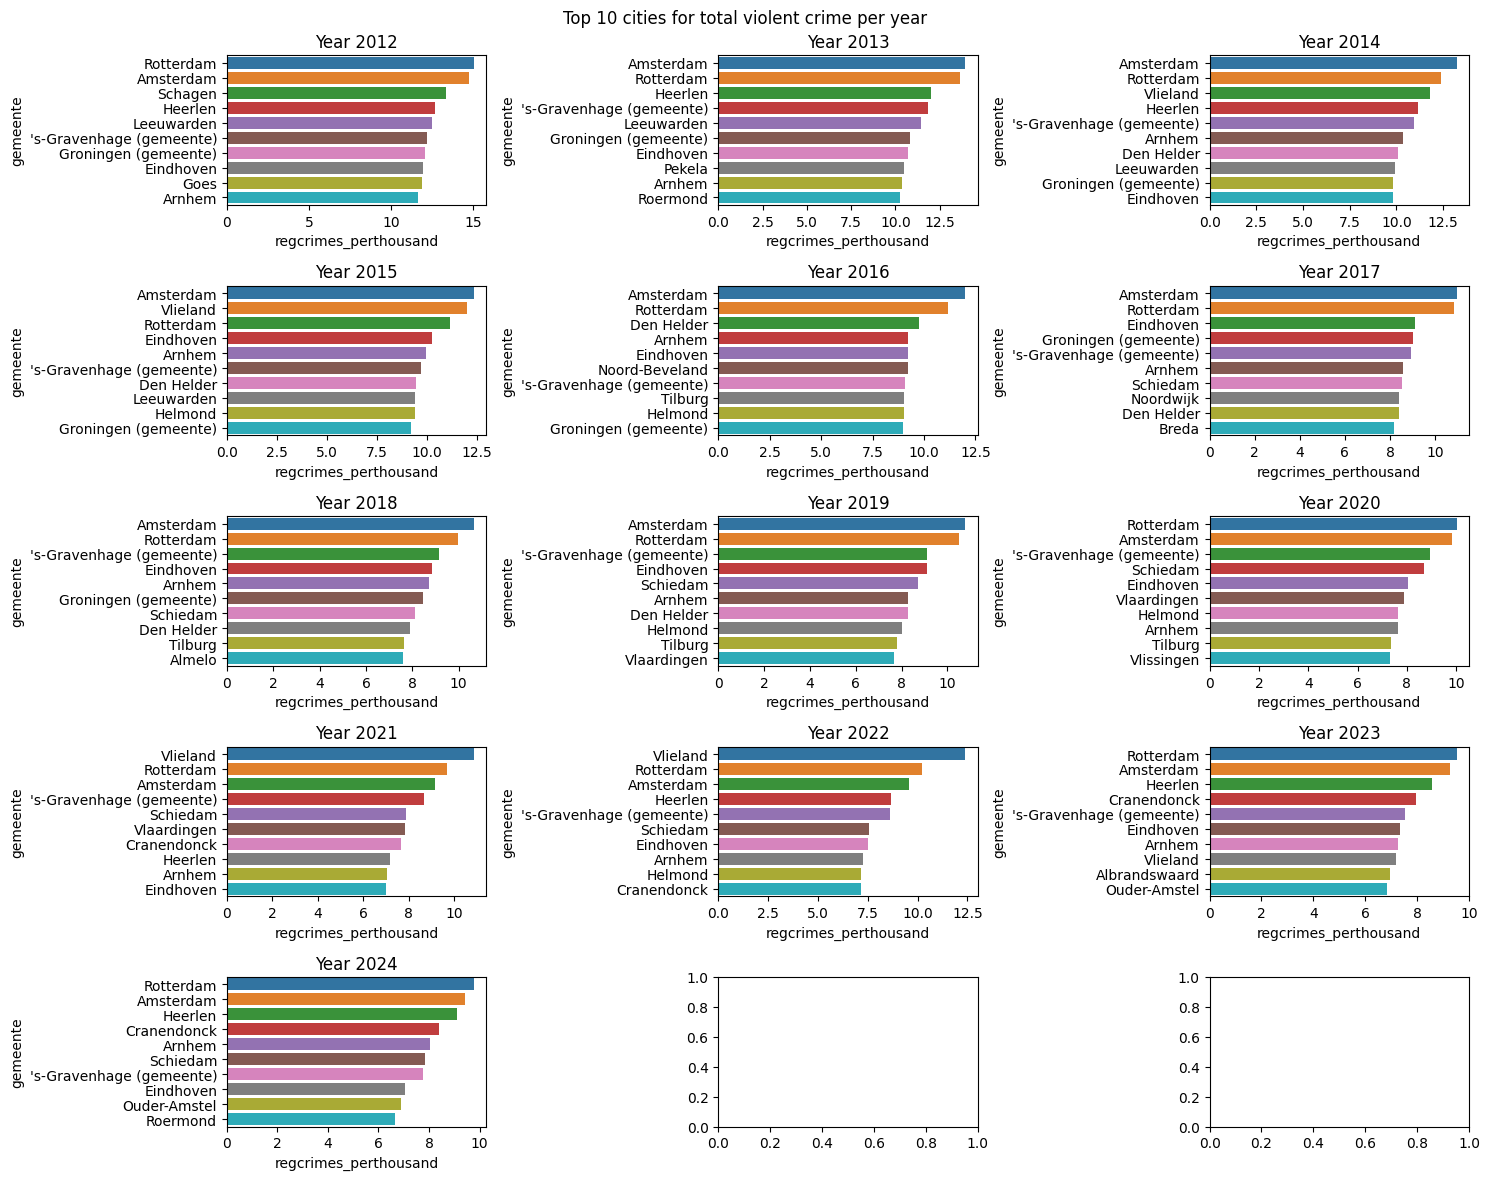

In [111]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))  
axes = axes.flatten()  # Make it easy to loop over

for i, df in enumerate(split_dfs):
    ax = axes[i]
    sns.barplot(data=df, x='regcrimes_perthousand', y='gemeente', hue='gemeente', orient='h', ax=ax)  
    ax.set_title(f"Year {years[i]}") 

plt.suptitle('Top 10 cities for total violent crime per year')
plt.tight_layout()
# plt.show()
# plt.xlim([0, 20])
# plt.xticks(rotation=80)
# plt.legend(split_dfs[0]['gemeente'])

## Time series of selected cities for total violent crime

In [114]:
## Manually select major/notable cities
r_cities = ['Amsterdam', 'Utrecht (gemeente)', 'Rotterdam', 'Delft', 'Leiden', "'s-Gravenhage (gemeente)"]
p_cities = ['Eindhoven', 'Tilburg', 'Breda', "'s-Hertogenbosch", 'Nijmegen', 'Arnhem', 'Groningen (gemeente)', 'Maastricht']
b_cities = ['Eindhoven', 'Tilburg', 'Breda', "'s-Hertogenbosch", 'Oss','Cranendonck', 'Bergen op Zoom']

randstad = totalcrime_pivot.loc[:,r_cities]
provincies = totalcrime_pivot.loc[:,p_cities]
brabant = totalcrime_pivot.loc[:,b_cities]

<Axes: xlabel='year'>

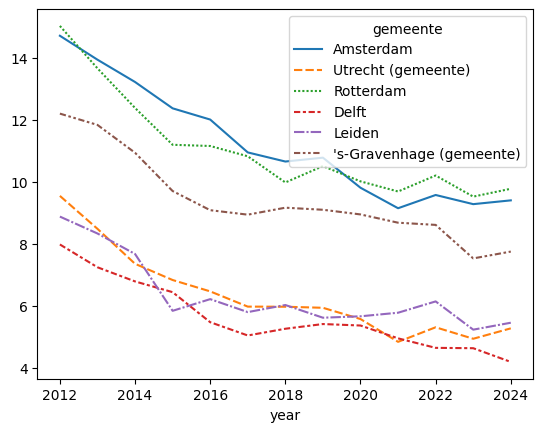

In [61]:
sns.lineplot(data=randstad)

<Axes: xlabel='year'>

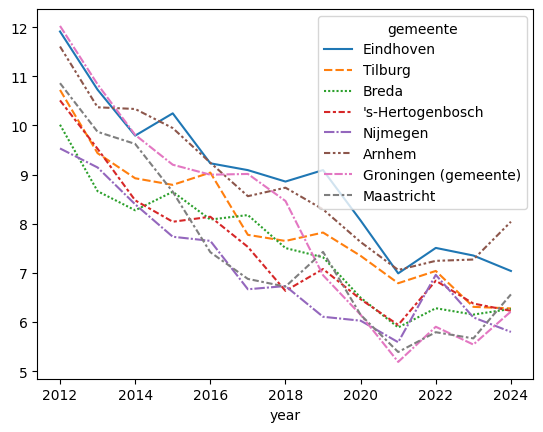

In [64]:
sns.lineplot(data=provincies)

<Axes: xlabel='year'>

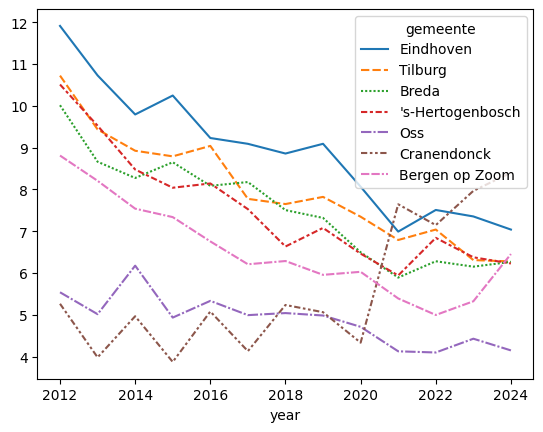

In [115]:
sns.lineplot(data=brabant)

In [59]:
## Top cities, all violent crime 2024
# Create a boolean mask for rows where year is 2024 and crime_cat is 'Total'
bool_2024 = (final_crimecities['year'] == 2024) & (final_crimecities['crime_cat'] == 'Total')

# Use the boolean mask to filter the DataFrame
final_crimecities[bool_2024].sort_values(by=['regcrimes_perthousand'], axis=0, ascending=False).head(10)

,gemeente,year,crime_cat,registered_crimes,popyearend,regcrimes_perthousand
3060,Rotterdam,2024,Total,6581.0,672960.0,9.779184
226,Amsterdam,2024,Total,8789.0,934526.0,9.404768
1565,Heerlen,2024,Total,797.0,87522.0,9.106282
748,Cranendonck,2024,Total,182.0,21665.0,8.400646
252,Arnhem,2024,Total,1362.0,169364.0,8.041851
3125,Schiedam,2024,Total,644.0,82232.0,7.831501
12,'s-Gravenhage (gemeente),2024,Total,4411.0,568945.0,7.752946
1128,Eindhoven,2024,Total,1753.0,249035.0,7.039171
2774,Ouder-Amstel,2024,Total,100.0,14532.0,6.881365
3034,Roermond,2024,Total,407.0,61210.0,6.649240


In [60]:
## Top cities, all violent crime 2012
# Create a boolean mask for rows where year is 2024 and crime_cat is 'Total'
bool_2012 = (final_crimecities['year'] == 2012) & (final_crimecities['crime_cat'] == 'Total')

# Use the boolean mask to filter the DataFrame
final_crimecities[bool_2012].sort_values(by=['regcrimes_perthousand'], axis=0, ascending=False).head(10)

,gemeente,year,crime_cat,registered_crimes,popyearend,regcrimes_perthousand
3048,Rotterdam,2012,Total,9264.0,616294.0,15.031787
214,Amsterdam,2012,Total,11761.0,799278.0,14.714530
3087,Schagen,2012,Total,247.0,18566.0,13.303889
1553,Heerlen,2012,Total,1124.0,88747.0,12.665217
2007,Leeuwarden,2012,Total,1199.0,95949.0,12.496222
0,'s-Gravenhage (gemeente),2012,Total,6173.0,505856.0,12.203078
1358,Groningen (gemeente),2012,Total,2350.0,195418.0,12.025504
1116,Eindhoven,2012,Total,2602.0,218433.0,11.912120
1297,Goes,2012,Total,439.0,36971.0,11.874172
240,Arnhem,2012,Total,1739.0,149827.0,11.606720


## Ranked cities by sex crimes

In [62]:
sexcrimes_2024 = (final_crimecities['year'] == 2024) & (final_crimecities['crime_cat'] == 'Zedendelicten')

final_crimecities[sexcrimes_2024].sort_values(by=['regcrimes_perthousand'], axis=0, ascending=False).head(10)

,gemeente,year,crime_cat,registered_crimes,popyearend,regcrimes_perthousand
168,Ameland,2024,Zedendelicten,4.0,3800.0,1.052632
4445,Zwolle,2024,Zedendelicten,137.0,133810.0,1.023840
1858,Hulst,2024,Zedendelicten,27.0,27378.0,0.986193
1598,Den Helder,2024,Zedendelicten,53.0,56662.0,0.935371
1624,Helmond,2024,Zedendelicten,89.0,96551.0,0.921793
233,Arnhem,2024,Zedendelicten,153.0,169364.0,0.903380
3158,Rotterdam,2024,Zedendelicten,600.0,672960.0,0.891583
4198,Winterswijk,2024,Zedendelicten,25.0,29232.0,0.855227
2534,Nijmegen,2024,Zedendelicten,158.0,189007.0,0.835948
3301,Sliedrecht,2024,Zedendelicten,22.0,26601.0,0.827037


In [63]:
kinderporno_2024 = (final_crimecities['year'] == 2024) & (final_crimecities['crime_cat'] == 'Kinderporno')

final_crimecities[kinderporno_2024].sort_values(by=['regcrimes_perthousand'], axis=0, ascending=False).head(10)

,gemeente,year,crime_cat,registered_crimes,popyearend,regcrimes_perthousand
40533,Baarn,2024,Kinderporno,6.0,25184.0,0.238247
40806,Boekel,2024,Kinderporno,2.0,11465.0,0.174444
42314,Leeuwarden,2024,Kinderporno,22.0,129973.0,0.169266
44329,Westerveld,2024,Kinderporno,3.0,19983.0,0.150128
41872,Helmond,2024,Kinderporno,14.0,96551.0,0.145001
40546,Barendrecht,2024,Kinderporno,7.0,48550.0,0.144181
41846,Den Helder,2024,Kinderporno,8.0,56662.0,0.141188
44056,Venray,2024,Kinderporno,6.0,44807.0,0.133908
42184,Kerkrade,2024,Kinderporno,6.0,45490.0,0.131897
42821,Noord-Beveland,2024,Kinderporno,1.0,8046.0,0.124285


In [64]:
kinderprost_2024 = (final_crimecities['year'] == 2024) & (final_crimecities['crime_cat'] == 'Kinderprostitutie')

final_crimecities[kinderprost_2024].sort_values(by=['regcrimes_perthousand'], axis=0, ascending=False).head(10)

,gemeente,year,crime_cat,registered_crimes,popyearend,regcrimes_perthousand
45226,Bladel,2024,Kinderprostitutie,1.0,21006.0,0.047605
45889,Ermelo,2024,Kinderprostitutie,1.0,28131.0,0.035548
45057,Beekdaelen,2024,Kinderprostitutie,1.0,35824.0,0.027914
44823,Almelo,2024,Kinderprostitutie,1.0,74776.0,0.013373
47683,Putten,2024,Kinderprostitutie,0.0,24953.0,0.000000
47774,Rhenen,2024,Kinderprostitutie,0.0,20392.0,0.000000
47761,Rheden,2024,Kinderprostitutie,0.0,43782.0,0.000000
47748,Reusel-De Mierden,2024,Kinderprostitutie,0.0,13653.0,0.000000
47735,Renswoude,2024,Kinderprostitutie,0.0,5782.0,0.000000
47722,Renkum,2024,Kinderprostitutie,0.0,31490.0,0.000000


## Time series selected gemeenten of violent crime per capita

### Gemeentes with sharpest change in violent crime per capita (2012 -2024)

## Top gemeentes by violent crime per capita (2024)

### Homicides (moord, doodslag)

### Sex crime (zedendelicten, kinderporno, kinderprostitutie)